## Binary classification for prediction of the compound activity with respect to adenosine A2a receptor

### Almaz Gilmullin 760235219, Anastasiia Krokhina 659711595

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# ! pip install tqdm
from tqdm import tqdm
import joblib
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
target = 'aa2ar'
url = f'https://dude.docking.org//targets/{target}'
tables = './tables'
path_model = './models'
pics = './pics'

In [3]:
def dir_builder():
    if not os.path.exists(path_model):
        os.mkdir(path_model)
    if not os.path.exists(pics):
        os.mkdir(pics)
    if not os.path.exists(tables):
        os.mkdir(tables)

dir_builder()

In [4]:
active = pd.read_csv(f'{url}/actives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
inactive = pd.read_csv(f'{url}/inactives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
decoys = pd.read_csv(f'{url}/decoys_final.ism', header=None, sep=' ', on_bad_lines='skip')

In [5]:
active = pd.DataFrame({'smiles':active[0], 'label': [1]*len(active[0])})
active_size = active.shape[0]
active_size

3050

In [6]:
inactive = pd.DataFrame({'smiles': inactive[0], 'label': [0]*len(inactive[0])})
inactive_size = inactive.shape[0]
inactive_size

192

In [7]:
decoys = pd.DataFrame({'smiles':decoys[0], 'label': [0]*len(decoys[0])})
decoys_size = decoys.shape[0]
decoys_size

31550

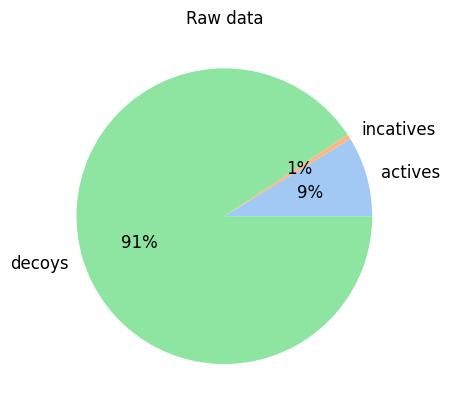

In [8]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, decoys_size]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Raw data')
# plt.show()
plt.savefig(f'{pics}/raw_data.png')

#### Our way to deal with imbalance - Combine inactives and decoys

In [9]:
size = active.shape[0] - inactive.shape[0]
split_decoys = decoys[:size]

In [10]:
balanced_data = pd.concat([active, inactive, split_decoys], ignore_index=True)
balanced_data

,smiles,label
0,c1cc2c(c(c1)Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[...,1
1,c1cc2c(cc1Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[C@...,1
2,c1cc2c(cc1Br)[nH]cc2CCOc3nc(c4c(n3)n(cn4)[C@H]...,1
3,c1cc2c(cc1CCNc3nc(c4c(n3)n(cn4)C5[C@@H]([C@@H]...,1
4,c1cc2c(cc1Cl)-c3c(c(nc(n3)N)c4ccc(o4)Br)C2,1
...,...,...
6095,CC1(OC(=O)C(=CNc2ccc(cc2)S(=O)(=O)Nc3ncccn3)C(...,0
6096,c1ccc2c(c1)[C@@]3(CCO2)C(=O)N(C(=O)N3)C[C@@H]4...,0
6097,c1ccc2c(c1)[C@]3(CCO2)C(=O)N(C(=O)N3)C[C@@H]4N...,0
6098,c1ccc(c(c1)[N+](=O)[O-])O[C@@H]2[C@@H]([C@@H](...,0


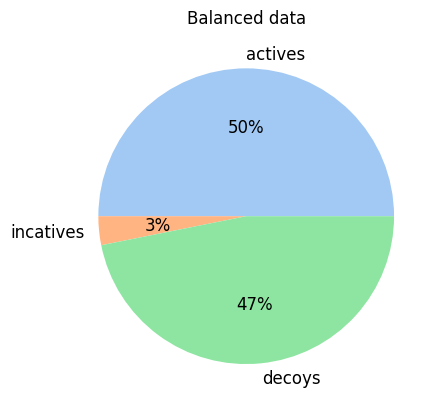

In [11]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, split_decoys.shape[0]]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Balanced data')
# plt.show()
plt.savefig(f'{pics}/balanced_data.png')

In [12]:
data = pd.concat([active, inactive, decoys], ignore_index=True)
data.shape

(34792, 2)

### Feature generation - RDKit Library

In [14]:
! pwd

/workspaces/a2a_binary_classifier


In [15]:
! hostname

codespaces-d0430c


In [16]:
# ! pip install rdkit??
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as MDC

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 7.2 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


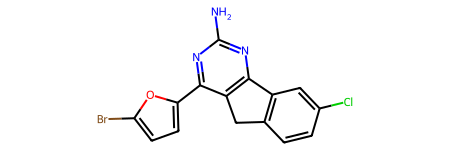

In [17]:
mol = Chem.MolFromSmiles(data.smiles[4])
mol

In [18]:
def RDkit_descriptors(data):
    mols = [Chem.MolFromSmiles(i) for i in data.smiles]
    desc_names = list(CalcMolDescriptors(mols[0]).keys())
    desc_names.append("label")
    mol_descs = []
    for i in tqdm(range(len(data))):
        descriptors = CalcMolDescriptors(mols[i])
        descriptors['label'] = data.label[i]
        mol_descs.append(descriptors)
    return mol_descs, desc_names

In [19]:
mol_descs,desc_names = RDkit_descriptors(data)
all_df = pd.DataFrame(mol_descs,columns=desc_names)
all_df

100%|██████████| 34792/34792 [06:59<00:00, 83.03it/s] 


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,1
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,12.933117,0.026874,-4.100987,0.602223,14.468750,461.496,438.312,461.125671,170,...,1,0,0,0,0,0,0,0,1,0
34788,5.666491,5.666491,0.191419,0.191419,0.400631,19.187500,455.592,426.360,455.221578,170,...,0,0,0,0,0,0,0,0,0,0
34789,13.336315,13.336315,0.076157,-3.927724,0.337664,12.322581,451.432,433.288,451.084949,164,...,1,0,0,0,0,0,0,0,0,0
34790,13.414551,13.414551,0.220101,-4.286701,0.417596,25.687500,468.395,443.195,468.118534,174,...,0,0,0,0,0,0,0,0,0,0


In [21]:
all_df.to_csv(f'{tables}/all_desc.csv',index=False)
all_df[:balanced_data.shape[0]].to_csv(f'{tables}/balanced_desc.csv',index=False)

## Can start from here

In [22]:
# new_df = pd.read_csv(f'{tables}/balanced_desc.csv')
new_df = pd.read_csv(f'{tables}/desc.csv')

In [23]:
X = new_df.iloc[:,:-1]
y = new_df.label
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,0
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,12.319151,12.319151,0.017230,-3.862462,0.430330,16.000000,404.404,388.276,404.079055,146,...,0,1,0,0,0,0,0,0,0,0
6096,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6097,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6098,11.109896,11.109896,0.052139,-1.484804,0.591959,33.259259,379.321,362.185,379.090331,144,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X.shape

(6100, 210)

### Filtering - deleting invariant data and highly correlated data

In [25]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

In [26]:
def filter_data(X):
    correlation_threshold = 0.9
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    column_names = X.columns
    X = X.drop(to_drop, axis=1)
    
    variance_threshold = 0.9
    sel = VarianceThreshold(threshold=(variance_threshold * (1 - variance_threshold)))
    X = sel.fit_transform(X)
    kept_features = sel.get_support(indices=True)
    X = pd.DataFrame(X, columns=column_names[kept_features])

    return X

X = filter_data(X)

In [27]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_CHGHI,BCUT2D_CHGLO,...,fr_NH1,fr_alkyl_carbamate,fr_allylic_oxid,fr_azide,fr_benzodiazepine,fr_bicyclic,fr_epoxide,fr_ester,fr_isocyan,fr_isothiocyan
0,10.337455,-1.272753,23.375000,505.329,79.918731,-2.326422,9.103951,-0.051090,1.375036,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.335047,-1.271941,23.375000,505.329,79.918731,-2.326422,9.103026,-0.051090,1.367373,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.333078,-1.271281,23.375000,505.329,79.918731,-2.326422,9.103025,-0.051090,1.360843,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.355554,-1.235039,25.218750,440.504,16.562573,-2.326488,5.825210,-0.051059,1.323034,1119.239263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.090409,0.226017,12.285714,362.614,79.918731,-2.005563,9.101988,0.552888,1.976391,875.350445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,12.319151,-3.862462,16.000000,404.404,32.233272,-2.415622,7.923083,-0.221879,1.710463,1011.077106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6096,13.479540,-3.870532,30.133333,433.490,32.238546,-2.592741,7.879540,-0.132775,1.454677,1041.505652,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6097,13.479540,-3.870532,30.133333,433.490,32.238546,-2.592741,7.879540,-0.132775,1.454677,1041.505652,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6098,11.109896,-1.484804,33.259259,379.321,16.756240,-2.624679,5.453392,-0.387812,1.490142,793.461585,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

label
1    327
0    283
Name: count, dtype: int64

### Scaling

In [29]:
scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SVC

In [30]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [31]:
svc = svm.SVC(random_state=0)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid = {'C':[1, 10, 100],
                  'gamma':[0.01,0.001, 'auto', 'scale']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring=scoring, refit='AUC', verbose=1, n_jobs=-1)

%time grid.fit(X_train, y_train)

print()
print(grid.best_params_)

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 30 folds for each of 12 candidates, totalling 360 fits


CPU times: user 1.23 s, sys: 367 ms, total: 1.59 s
Wall time: 1min 46s

{'C': 10, 'gamma': 'auto'}
Accuracy: 0.978688524590164
Mean ROC AUC: 0.9775072670491998


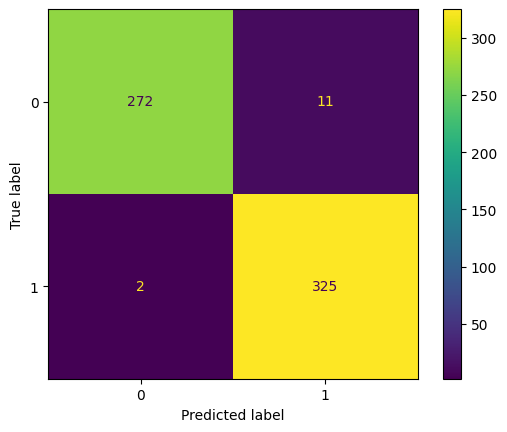

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()
plt.show()
# plt.savefig(f'{pics}/conf_scaled.jpg')

# Recheck

In [33]:

svc = svm.SVC(C=100, gamma=0.001)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# print("Accuracy:", accuracy)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       283
           1       0.96      0.99      0.97       327

    accuracy                           0.97       610
   macro avg       0.97      0.97      0.97       610
weighted avg       0.97      0.97      0.97       610



In [34]:
svc_filename = f'{path_model}/svc.sav'
joblib.dump(svc, svc_filename)

['./models/svc.sav']

In [35]:
# svc = joblib.load(svc_filename)

### Plotting the result

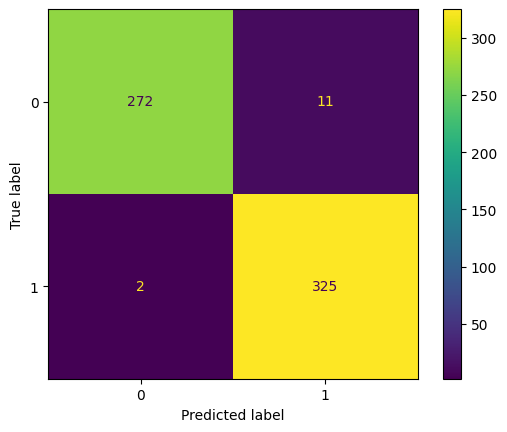

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
plt.show()
# plt.savefig(f'{pics}/conf_scal.jpg')

### SVC 2

In [37]:
svc_2 = svm.SVC(C=1, gamma=0.0001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(svc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=3)

svc_2 = svm.SVC(C=1, gamma=0.0001)
accuracy = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3)
print('Mean ROC AUC: %.3f' % mean(scores))
print('Accuracy: %.3f' % mean(accuracy))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END ................................ score: (test=0.992) total time=   0.6s
[CV] END ................................ score: (test=0.998) total time=   0.6s
[CV] END ................................ score: (test=0.995) total time=   0.5s
[CV] END ................................ score: (test=0.994) total time=   0.5s
[CV] END ................................ score: (test=0.995) total time=   0.5s
[CV] END ................................ score: (test=0.997) total time=   0.5s
[CV] END ................................ score: (test=0.999) total time=   0.6s
[CV] END ................................ score: (test=0.999) total time=   0.6s
[CV] END ................................ score: (test=0.997) total time=   0.4s
[CV] END ................................ score: (test=0.997) total time=   0.4s
[CV] END ................................ score: (test=0.998) total time=   0.4s
[CV] END ................................ score: (test=0.997) total time=   0.4s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END ................................ score: (test=0.978) total time=   0.5s
[CV] END ................................ score: (test=0.976) total time=   0.5s
[CV] END ................................ score: (test=0.976) total time=   0.4s
[CV] END ................................ score: (test=0.974) total time=   0.4s
[CV] END ................................ score: (test=0.974) total time=   0.4s
[CV] END ................................ score: (test=0.980) total time=   0.5s
[CV] END ................................ score: (test=0.984) total time=   0.5s
[CV] END ................................ score: (test=0.989) total time=   0.6s
[CV] END ................................ score: (test=0.984) total time=   0.4s
[CV] END ................................ score: (test=0.978) total time=   0.5s
[CV] END ................................ score: (test=0.984) total time=   0.4s
[CV] END ................................ score: (test=0.980) total time=   0.4s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


In [38]:
svc_2_filename = f'{path_model}/svc_2.sav'
joblib.dump(svc_2, svc_2_filename)

['./models/svc_2.sav']

In [39]:
# svc_2 = joblib.load(svc_2_filename)

## Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# accuracy_nb = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy_nb)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       283
           1       0.90      0.97      0.93       327

    accuracy                           0.92       610
   macro avg       0.93      0.92      0.92       610
weighted avg       0.93      0.92      0.92       610



In [42]:
gaus_filename = f'{path_model}/gaussian.sav'
joblib.dump(nb, gaus_filename)

['./models/gaussian.sav']

In [43]:
# nb = joblib.load(gaus_filename)

### Logistic Regression

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

In [45]:
SEED = 42

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])

unscaled_lr = Pipeline([('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])

scores = cross_val_score(estimator=lr, X=X_train, y=y_train, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)

print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

lr.fit(X_train, y_train);

scores = [0.98528294 0.98949516 0.98788924 0.98731485 0.98613692] 
mean score = 0.98722 +/- 0.00145


In [46]:
df_score = pd.DataFrame(data={'score': lr['lr'].coef_[0]}, index=X.columns).sort_values(by='score')
# df.plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [47]:
df_score

,score
BCUT2D_CHGLO,-3.223946
Kappa2,-2.523274
Kappa3,-1.697025
Chi4n,-1.641638
PEOE_VSA9,-1.397618
...,...
PEOE_VSA12,1.145546
SlogP_VSA12,1.727905
PEOE_VSA5,2.171783
PEOE_VSA7,2.500676


In [48]:
y_pred = lr.predict(X_test)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

# accuracy_nb = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy_nb)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       283
           1       0.94      0.98      0.96       327

    accuracy                           0.96       610
   macro avg       0.96      0.95      0.96       610
weighted avg       0.96      0.96      0.96       610



#### We have high accuracy and high AUC score in classification, it's better to go to regression to better progress

In [50]:
lofit_filename = f'{path_model}/svc.sav'
joblib.dump(lr, lofit_filename)

['./models/svc.sav']

In [51]:
# lr = joblib.load(logit_filename)

### Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
values = [i for i in range(1, 21)]
train_scores = []
test_scores = []
for i in values:
    model = DecisionTreeClassifier(max_depth=i)

    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.899, test: 0.887
>2, train: 0.925, test: 0.903
>3, train: 0.948, test: 0.933
>4, train: 0.954, test: 0.933
>5, train: 0.965, test: 0.941
>6, train: 0.971, test: 0.943
>7, train: 0.976, test: 0.946
>8, train: 0.981, test: 0.952
>9, train: 0.985, test: 0.956
>10, train: 0.988, test: 0.949
>11, train: 0.991, test: 0.946
>12, train: 0.993, test: 0.951
>13, train: 0.995, test: 0.944
>14, train: 0.995, test: 0.949
>15, train: 0.996, test: 0.948
>16, train: 0.997, test: 0.939
>17, train: 0.997, test: 0.946
>18, train: 0.997, test: 0.952
>19, train: 0.997, test: 0.949
>20, train: 0.998, test: 0.956


## Plot

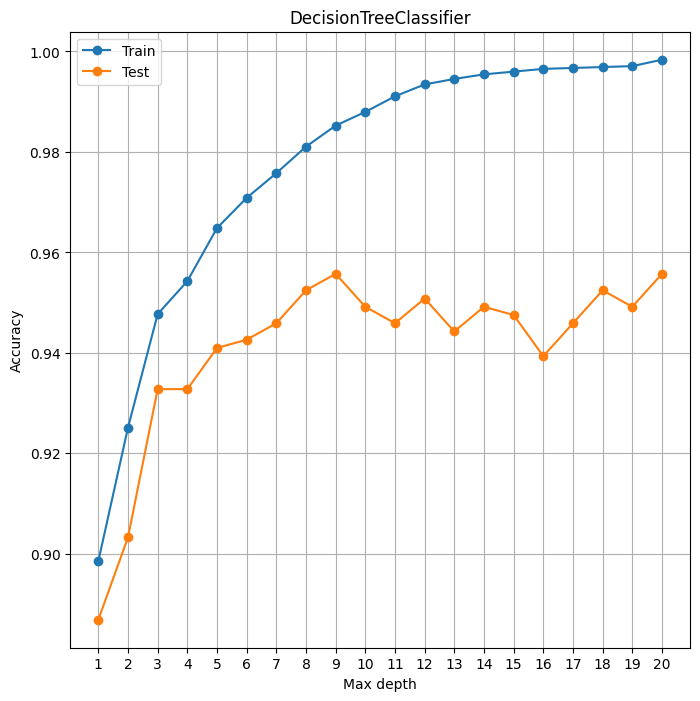

In [54]:
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 21))
plt.grid()
plt.title('DecisionTreeClassifier')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
# plt.show()
plt.savefig(f'{pics}/clf_dtree_balanced.png')

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

values = [i for i in range(1, 21)]
train_scores = []
test_scores = []
for i in values:
    rf = RandomForestClassifier(max_depth=i)

    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.997, test: 0.941
>2, train: 0.997, test: 0.949
>3, train: 0.997, test: 0.948
>4, train: 0.997, test: 0.944
>5, train: 0.997, test: 0.948
>6, train: 0.997, test: 0.952
>7, train: 0.997, test: 0.949
>8, train: 0.997, test: 0.946
>9, train: 0.997, test: 0.952
>10, train: 0.997, test: 0.951
>11, train: 0.997, test: 0.951
>12, train: 0.998, test: 0.954
>13, train: 0.997, test: 0.951
>14, train: 0.997, test: 0.948
>15, train: 0.997, test: 0.952
>16, train: 0.997, test: 0.946
>17, train: 0.997, test: 0.939
>18, train: 0.997, test: 0.949
>19, train: 0.997, test: 0.949
>20, train: 0.997, test: 0.949


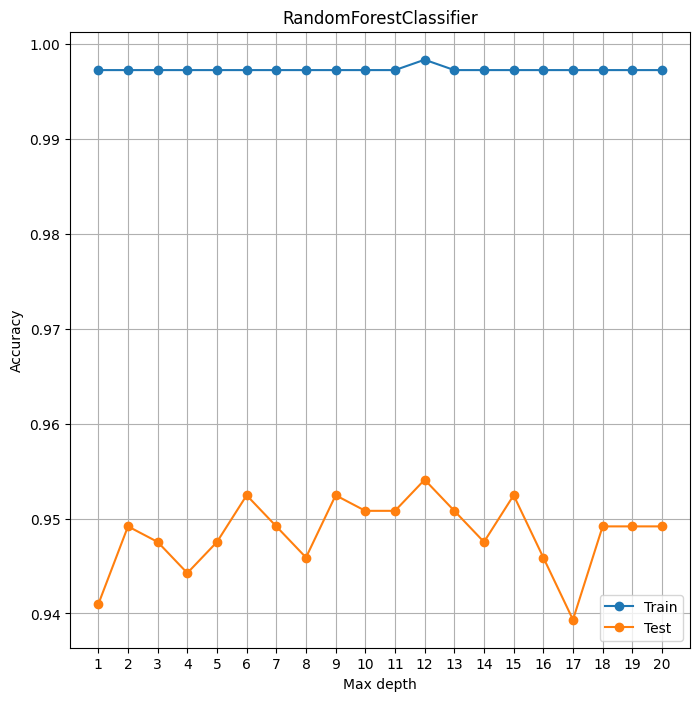

In [56]:
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 21))
plt.grid()
plt.title('RandomForestClassifier')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
plt.show()
# plt.savefig(f'{pics}/clf_rf_balanced.png')

In [57]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9655737704918033